In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
data = pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016(222).csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [6]:
data = data.rename(columns={"Year_of_Release": "Year", 
                            "NA_Sales": "NA",
                            "EU_Sales": "EU",
                            "JP_Sales": "JP",
                            "Other_Sales": "Other",
                            "Global_Sales": "Global"})

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16717 non-null  object 
 1   Platform      16719 non-null  object 
 2   Year          16450 non-null  float64
 3   Genre         16717 non-null  object 
 4   Publisher     16665 non-null  object 
 5   NA            16719 non-null  float64
 6   EU            16719 non-null  float64
 7   JP            16719 non-null  float64
 8   Other         16719 non-null  float64
 9   Global        16719 non-null  float64
 10  Critic_Score  8137 non-null   float64
 11  Critic_Count  8137 non-null   float64
 12  User_Score    10015 non-null  object 
 13  User_Count    7590 non-null   float64
 14  Developer     10096 non-null  object 
 15  Rating        9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [8]:
data = data[data["Year"].notnull()]
data = data[data["Genre"].notnull()]

In [9]:
data["Year"] = data["Year"].apply(int)
data["Age"] = 2018 - data["Year"]

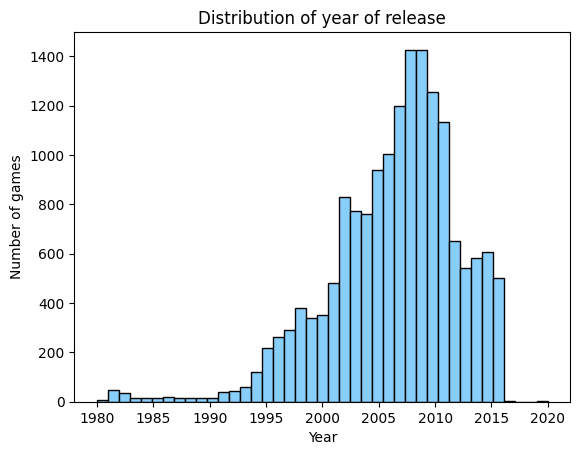

In [10]:
num_years = data["Year"].max() - data["Year"].min() + 1
plt.hist(data["Year"], bins=num_years, color="lightskyblue", edgecolor="black")
plt.title("Distribution of year of release")
plt.xlabel("Year")
plt.ylabel("Number of games");

In [11]:
data["User_Score"] = data["User_Score"].replace("tbd", np.nan).astype(float)

In [12]:
scored = data.dropna(subset=["User_Score", "Critic_Score", "Rating"])

In [13]:
data.shape

(16448, 17)

In [14]:
scored["Platform"].unique(), scored["Genre"].unique(), scored["Rating"].unique()

(array(['Wii', 'DS', 'X360', 'PS3', 'PS2', '3DS', 'PS4', 'PS', 'XB', 'PC',
        'PSP', 'WiiU', 'GC', 'GBA', 'XOne', 'PSV', 'DC'], dtype=object),
 array(['Sports', 'Racing', 'Platform', 'Misc', 'Action', 'Puzzle',
        'Shooter', 'Fighting', 'Simulation', 'Role-Playing', 'Adventure',
        'Strategy'], dtype=object),
 array(['E', 'M', 'T', 'E10+', 'AO', 'K-A', 'RP'], dtype=object))

In [15]:
import category_encoders as ce
# Select the numeric columns
numeric_subset = scored.select_dtypes("number").drop(columns=["NA", "EU", "JP", "Other", "Year"])

# Select the categorical column
categorical_subset = scored[["Platform", "Genre", "Rating"]]

# One hot encode
encoder = ce.one_hot.OneHotEncoder()
categorical_subset = encoder.fit_transform(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score 
correlations = features.corr()["Global"].dropna().sort_values()

In [16]:
correlations.head(5)

Platform_10   -0.081154
Rating_3      -0.073834
Platform_9    -0.061537
Genre_12      -0.053254
Genre_11      -0.044695
Name: Global, dtype: float64

In [17]:
correlations.tail(5)

User_Score      0.088427
Critic_Score    0.237582
User_Count      0.264133
Critic_Count    0.290394
Global          1.000000
Name: Global, dtype: float64

In [18]:
from sklearn.model_selection import train_test_split
basic_target = pd.Series(features["Global"])
basic_features = features.drop(columns="Global")
features_train, features_test, target_train, target_test = train_test_split(basic_features, basic_target, 
                                                                            test_size=0.2,
                                                                            random_state=42)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)
(4427, 42)
(1107, 42)
(4427,)
(1107,)


def mae(y_true, y_pred):
    return np.average(abs(y_true - y_pred))


baseline_guess = np.median(target_train)
basic_baseline_mae = mae(target_test, baseline_guess)
print("Baseline guess for global sales is: {:.02f}".format(baseline_guess))
print("Baseline Performance on the test set: MAE = {:.04f}".format(basic_baseline_mae))



(5460, 41)
(1366, 41)
(5460,)
(1366,)
Baseline guess for global sales is: 0.29
Baseline Performance on the test set: MAE = 0.6826


In [19]:
from sklearn.metrics import r2_score

# Create an array of predictions (all same as the median guess)
baseline_predictions = np.full(shape=len(target_test), fill_value=baseline_guess)

# Calculate R² score
baseline_r2 = r2_score(target_test, baseline_predictions)

print("R² Score for baseline model: {:.4f}".format(baseline_r2))

from sklearn.metrics import mean_squared_error

baseline_mse = mean_squared_error(target_test, baseline_predictions)
print("Baseline MSE: {:.4f}".format(baseline_mse))



R² Score for baseline model: -0.0998
Baseline MSE: 2.9901


In [20]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [21]:
from sklearn.metrics import r2_score

def fit_and_evaluate(model):
    # Train the model
    model.fit(features_train, target_train)
    
    # Make predictions
    model_pred = model.predict(features_test)
    
    # Calculate MAE
    model_mae = mae(target_test, model_pred)
    
    # Calculate R² Score
    model_r2 = r2_score(target_test, model_pred)
    
    # Print and return both metrics
    print(f"Model Performance:\n - MAE = {model_mae:.4f}\n - R² Score = {model_r2:.4f}")
    
    return model_mae, model_r2


In [22]:
lr = LinearRegression()
results = fit_and_evaluate(lr)

print("Linear Regression Performance on the test set:\n - MAE = {:.04f}\n - R² = {:.04f}".format(results[0], results[1]))


Model Performance:
 - MAE = 0.7104
 - R² Score = 0.2762
Linear Regression Performance on the test set:
 - MAE = 0.7104
 - R² = 0.2762


In [23]:
svm = SVR(C=1000, gamma=0.1)
svm_mae, svm_r2 = fit_and_evaluate(svm)

print("Support Vector Machine Regression Performance on the test set:\n - MAE = {:.04f}\n - R² = {:.04f}".format(svm_mae, svm_r2))


Model Performance:
 - MAE = 0.7793
 - R² Score = 0.0557
Support Vector Machine Regression Performance on the test set:
 - MAE = 0.7793
 - R² = 0.0557


In [24]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae, random_forest_r2 = fit_and_evaluate(random_forest)

print("Random Forest Regression Performance on the test set:")
print(" - MAE = {:.04f}".format(random_forest_mae))
print(" - R² Score = {:.04f}".format(random_forest_r2))

Model Performance:
 - MAE = 0.5224
 - R² Score = 0.4214
Random Forest Regression Performance on the test set:
 - MAE = 0.5224
 - R² Score = 0.4214


In [25]:
gradient_boosting = GradientBoostingRegressor(random_state=60)
gradient_boosting_mae, gradient_boosting_r2 = fit_and_evaluate(gradient_boosting)

print("Gradient Boosting Regression Performance on the test set:")
print(" - MAE = {:.04f}".format(gradient_boosting_mae))
print(" - R² Score = {:.04f}".format(gradient_boosting_r2))


Model Performance:
 - MAE = 0.5344
 - R² Score = 0.3853
Gradient Boosting Regression Performance on the test set:
 - MAE = 0.5344
 - R² Score = 0.3853


In [26]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae, knn_r2 = fit_and_evaluate(knn)

print("K-Nearest Neighbors Regression Performance on the test set:")
print(" - MAE = {:.04f}".format(knn_mae))
print(" - R² Score = {:.04f}".format(knn_r2))


Model Performance:
 - MAE = 0.7056
 - R² Score = 0.0906
K-Nearest Neighbors Regression Performance on the test set:
 - MAE = 0.7056
 - R² Score = 0.0906


In [27]:
ridge = Ridge(alpha=10)
ridge_mae, ridge_r2 = fit_and_evaluate(ridge)

print("Ridge Regression Performance on the test set:")
print(" - MAE = {:.04f}".format(ridge_mae))
print(" - R² Score = {:.04f}".format(ridge_r2))

Model Performance:
 - MAE = 0.7075
 - R² Score = 0.2766
Ridge Regression Performance on the test set:
 - MAE = 0.7075
 - R² Score = 0.2766


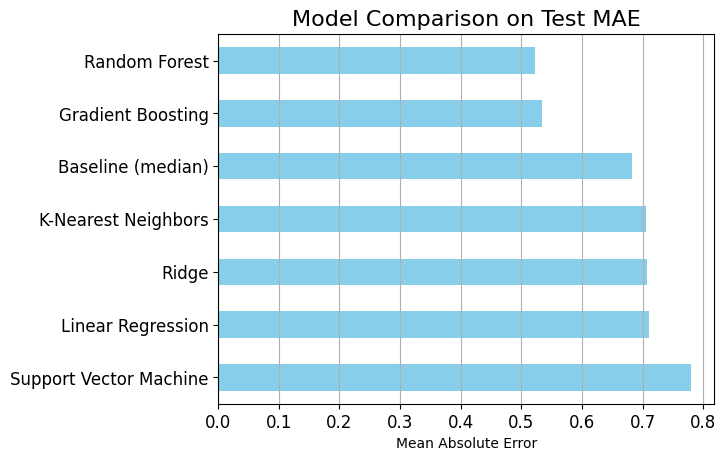

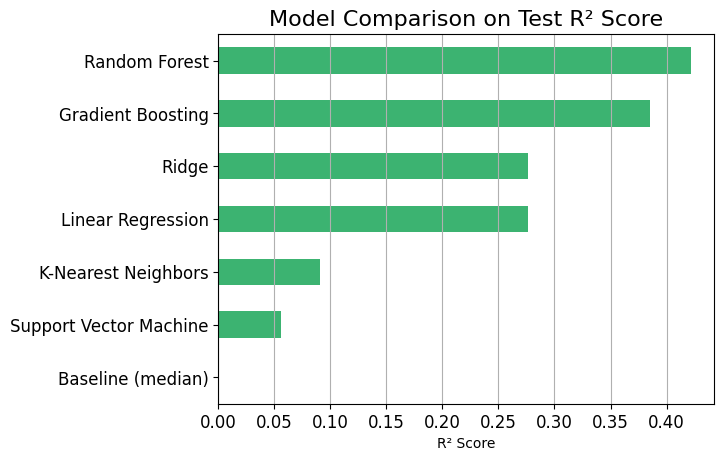


📊 Final Model Scores:
                 Model      MAE       R2
         Random Forest 0.522423 0.421445
     Gradient Boosting 0.534372 0.385331
                 Ridge 0.707519 0.276619
     Linear Regression 0.710358 0.276233
   K-Nearest Neighbors 0.705605 0.090571
Support Vector Machine 0.779337 0.055682
     Baseline (median) 0.682599 0.000000


In [28]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Updated function to return both MAE and R²
def fit_and_evaluate(model):
    model.fit(features_train, target_train)
    preds = model.predict(features_test)
    return mae(target_test, preds), r2_score(target_test, preds)

# Fit models
lr_mae, lr_r2 = fit_and_evaluate(LinearRegression())
svm_mae, svm_r2 = fit_and_evaluate(SVR(C=1000, gamma=0.1))
random_forest_mae, random_forest_r2 = fit_and_evaluate(RandomForestRegressor(random_state=60))
gradient_boosting_mae, gradient_boosting_r2 = fit_and_evaluate(GradientBoostingRegressor(random_state=60))
knn_mae, knn_r2 = fit_and_evaluate(KNeighborsRegressor(n_neighbors=10))
ridge_mae, ridge_r2 = fit_and_evaluate(Ridge(alpha=10))

# Baseline R² is always 0 (predicting median is like constant model)
baseline_guess = np.median(target_train)
basic_baseline_mae = mae(target_test, baseline_guess)
basic_baseline_r2 = 0

# Store in DataFrame
model_comparison = pd.DataFrame({
    "Model": ["Linear Regression", "Support Vector Machine", "Random Forest", 
              "Gradient Boosting", "K-Nearest Neighbors", "Baseline (median)", "Ridge"],
    "MAE": [lr_mae, svm_mae, random_forest_mae, gradient_boosting_mae,
            knn_mae, basic_baseline_mae, ridge_mae],
    "R2": [lr_r2, svm_r2, random_forest_r2, gradient_boosting_r2,
           knn_r2, basic_baseline_r2, ridge_r2]
})

# Plot MAE
model_comparison.sort_values("MAE", ascending=False).plot(
    x="Model", y="MAE", kind="barh", color="skyblue", legend=False)
plt.title("Model Comparison on Test MAE", size=16)
plt.xlabel("Mean Absolute Error")
plt.ylabel("")
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(axis='x')
plt.show()

# Plot R²
model_comparison.sort_values("R2", ascending=True).plot(
    x="Model", y="R2", kind="barh", color="mediumseagreen", legend=False)
plt.title("Model Comparison on Test R² Score", size=16)
plt.xlabel("R² Score")
plt.ylabel("")
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(axis='x')
plt.show()

# Print final scores
print("\n📊 Final Model Scores:")
print(model_comparison.sort_values("R2", ascending=False).to_string(index=False))


In [2]:
data["Platform"].nunique()

NameError: name 'data' is not defined

In [ ]:
platforms = {"Playstation" : ["PS", "PS2", "PS3", "PS4"],
             "Xbox" : ["XB", "X360", "XOne"], 
             "PC" : ["PC"],
             "Nintendo" : ["Wii", "WiiU"],
             "Portable" : ["GB", "GBA", "GC", "DS", "3DS", "PSP", "PSV"]}

In [ ]:
def donut_chart(column, palette="Set2"):
    values = column.value_counts().values
    labels = column.value_counts().index
    plt.pie(values, colors=sns.color_palette(palette), 
            labels=labels, autopct="%1.1f%%", 
            startangle=90, pctdistance=0.85)
    #draw circle
    centre_circle = plt.Circle((0,0), 0.70, fc="white")
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)


def get_group_label(x, groups=None):
    if groups is None:
        return "Other"
    else:
        for key, val in groups.items():
            if x in val:
                return key
        return "Other"
data["Grouped_Platform"] = data["Platform"].apply(lambda x: get_group_label(x, groups=platforms))
donut_chart(data["Grouped_Platform"])
plt.title("Groups of platforms")
plt.axis("equal");


In [ ]:
donut_chart(data["Genre"], palette="muted")
plt.title("Genres")
plt.axis("equal");


In [ ]:
scored["Grouped_Platform"] = scored["Platform"].apply(lambda x: get_group_label(x, platforms))
donut_chart(scored["Grouped_Platform"])
plt.title("Groups of platforms for games with score")
plt.axis("equal");

In [ ]:
scored["Weighted_Score"] = (scored["User_Score"] * 10 * scored["User_Count"] + 
                            scored["Critic_Score"] * scored["Critic_Count"]) / (scored["User_Count"] + scored["Critic_Count"])
devs = pd.DataFrame({"dev": scored["Developer"].value_counts().index,
                     "count": scored["Developer"].value_counts().values})
m_score = pd.DataFrame({"dev": scored.groupby("Developer")["Weighted_Score"].mean().index,
                        "mean_score": scored.groupby("Developer")["Weighted_Score"].mean().values})
devs = pd.merge(devs, m_score, on="dev")
devs = devs.sort_values(by="count", ascending=True)
devs["percent"] = devs["count"] / devs["count"].sum()
devs["top%"] = devs["percent"].cumsum() * 100
n_groups = 5
devs["top_group"] = (devs["top%"] * n_groups) // 100 + 1
devs["top_group"].iloc[-1] = n_groups
devs

In [ ]:

from matplotlib.lines import Line2D

pal = sns.color_palette("RdYlGn", n_groups)
g = sns.JointGrid(x="top%", y="mean_score", data=devs, height=12)
legend_elements = []
for k in range(0, n_groups):
    g.ax_joint.scatter(devs[devs["top_group"]==k+1]["top%"], 
                       devs[devs["top_group"]==k+1]["mean_score"],
                       color=pal[k], alpha=.9, edgecolor="black")
    legend_elements.append(Line2D([0], [0], label=k+1, marker="o", ls="", 
                                  mfc=pal[k], mec=pal[k], alpha=.9, markersize=15))
    g.ax_marg_x.bar(np.arange(k * 100 / n_groups, (k+1) * 100 / n_groups), 
                    devs[devs["top_group"]==k+1].shape[0], 
                    width=1, align="edge", color=pal[k], alpha=.9)
g.ax_marg_y.hist(devs["mean_score"], color=pal[-1], alpha=.9,
                 orientation="horizontal", bins=25, edgecolor="white")
g.set_axis_labels("Top %", "Mean Weighted Score")
g.ax_joint.tick_params(labelsize=15)
g.ax_marg_x.grid(False)
g.ax_marg_y.grid(False)
#g.ax_joint.legend(handles=legend_elements, title="Top Group", loc=4)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Developers");

In [ ]:
data.shape

In [ ]:
# Fill missing numeric columns with 0.0
data["Critic_Score"] = data["Critic_Score"].fillna(0.0)
data["Critic_Count"] = data["Critic_Count"].fillna(0.0)
data["User_Score"] = data["User_Score"].fillna(0.0)
data["User_Count"] = data["User_Count"].fillna(0.0)

# Join devs info
data = data.join(devs.set_index("dev")["top_group"], on="Developer")
data = data.rename(columns={"top_group": "Developer_Rank"})

# Fill remaining nulls
data["Developer_Rank"] = data["Developer_Rank"].fillna(0.0)
data["Rating"] = data["Rating"].fillna("None")


In [ ]:
data["Weighted_Score"] = (
    (data["User_Score"] * 10 * data["User_Count"] + 
     data["Critic_Score"] * data["Critic_Count"]) /
    (data["User_Count"] + data["Critic_Count"])
)

data["Weighted_Score"] = data["Weighted_Score"].fillna(0.0)


In [ ]:
data.info()

In [ ]:
import pandas as pd
import numpy as np

# Select the numeric columns
numeric_subset = data.select_dtypes("number").drop(columns=["NA", "EU", "JP", "Other", "Year"])

# Select the categorical columns
categorical_subset = data[["Grouped_Platform", "Genre", "Rating"]]

# One-Hot Encode the categorical columns
categorical_subset = pd.get_dummies(categorical_subset, drop_first=True)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis=1)

# Find correlations with the score 
correlations = features.corr()["Global"].dropna().sort_values()


In [ ]:
target = pd.Series(features["Global"])
features = features.drop(columns="Global")
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2,
                                                                            random_state=42)
baseline_guess = np.median(target_train)
baseline_mae = mae(target_test, baseline_guess)
print("Baseline guess for global sales is: {:.02f}".format(baseline_guess))
print("Baseline Performance on the test set: MAE = {:.04f}".format(baseline_mae))

In [ ]:
# Loss function to be optimized
loss = ["ls", "lad", "huber"]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ["auto", "sqrt", "log2", None]

hyperparameter_grid = {"loss": loss,
                       "max_depth": max_depth,
                       "min_samples_leaf": min_samples_leaf,
                       "min_samples_split": min_samples_split,
                       "max_features": max_features}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV



model = GradientBoostingRegressor(random_state = 42)

random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=20, 
                               scoring="neg_mean_absolute_error",
                               n_jobs=-1, verbose=1, 
                               return_train_score=True,
                               random_state=42)
random_cv.fit(features_train, target_train);




trees_grid = {"n_estimators": [50, 100, 150, 200, 250, 300]}

model = random_cv.best_estimator_
grid_search = GridSearchCV(estimator=model, param_grid=trees_grid, cv=4, 
                           scoring="neg_mean_absolute_error", verbose=1,
                           n_jobs=-1, return_train_score=True)
grid_search.fit(features_train, target_train);




results = pd.DataFrame(grid_search.cv_results_)

plt.plot(results["param_n_estimators"], -1 * results["mean_test_score"], label = "Testing Error")
plt.plot(results["param_n_estimators"], -1 * results["mean_train_score"], label = "Training Error")
plt.xlabel("Number of Trees"); plt.ylabel("Mean Abosolute Error"); plt.legend();
plt.title("Performance vs Number of Trees");




final_model = grid_search.best_estimator_
final_pred = final_model.predict(features_test)
final_mae = mae(target_test, final_pred)
print("Final model performance on the test set: MAE = {:.04f}.".format(final_mae))

In [ ]:
final_model = grid_search.best_estimator_
final_pred = final_model.predict(features_test)
final_mae = mae(target_test, final_pred)
print("Final model performance on the test set: MAE = {:.04f}.".format(final_mae))

In [ ]:
from sklearn.metrics import mean_absolute_error as mae, r2_score

final_model = grid_search.best_estimator_
final_pred = final_model.predict(features_test)

# Evaluation metrics
final_mae = mae(target_test, final_pred)
final_r2 = r2_score(target_test, final_pred)

print("Final model performance on the test set: MAE = {:.04f}".format(final_mae))
print("Final model performance on the test set: R² = {:.04f}".format(final_r2))
